<a href="https://colab.research.google.com/github/emrunali/Codon_Usage_Clustermap/blob/main/123B_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez, SeqIO
from Bio.Seq import CodonTable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Enter comma-separated accession numbers: NM_001354622, NM_001324522.1, NM_031053.2, XM_038570374.1, NM_001075994.2, NM_001172367.1, XM_054681636.1, XM_054057702.1, XM_019418653.2, XM_006271413.4, NM_200659.1, XM_057316052.1, XM_037988472.1, XM_021284243.1, XM_002716167.4, XM_014154294.2, XM_027451459.2, XM_006077048.3, XM_042860299.1, XM_007904047.2, XM_015811737.1, XM_005485879.3, XM_025039320.1, XM_014562304.2, XM_015943877.2, XM_049870796.1, XM_021238687.1, XM_042998512.1, XM_007945683.2, NM_001281613.1, XM_039461845.1, XM_015618320.3, XM_015854215.2, XM_011738693.2, XM_005600830.3, XM_023514004.1, XM_005795201.2, XM_013973336.2, XM_033165325.1
Enter the codon table ID (1-33): 1


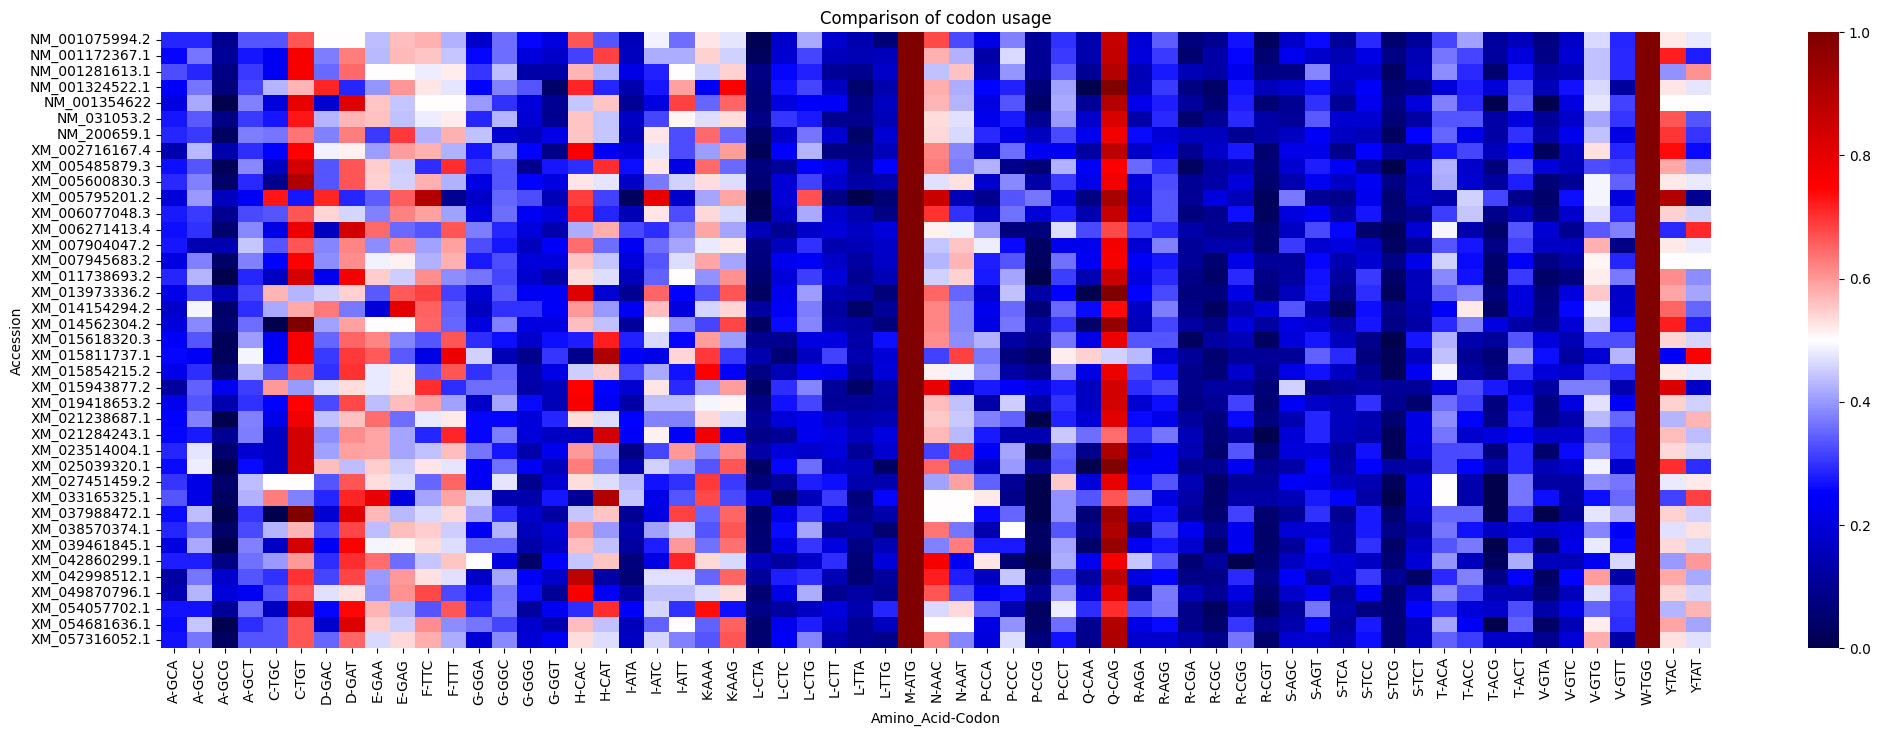

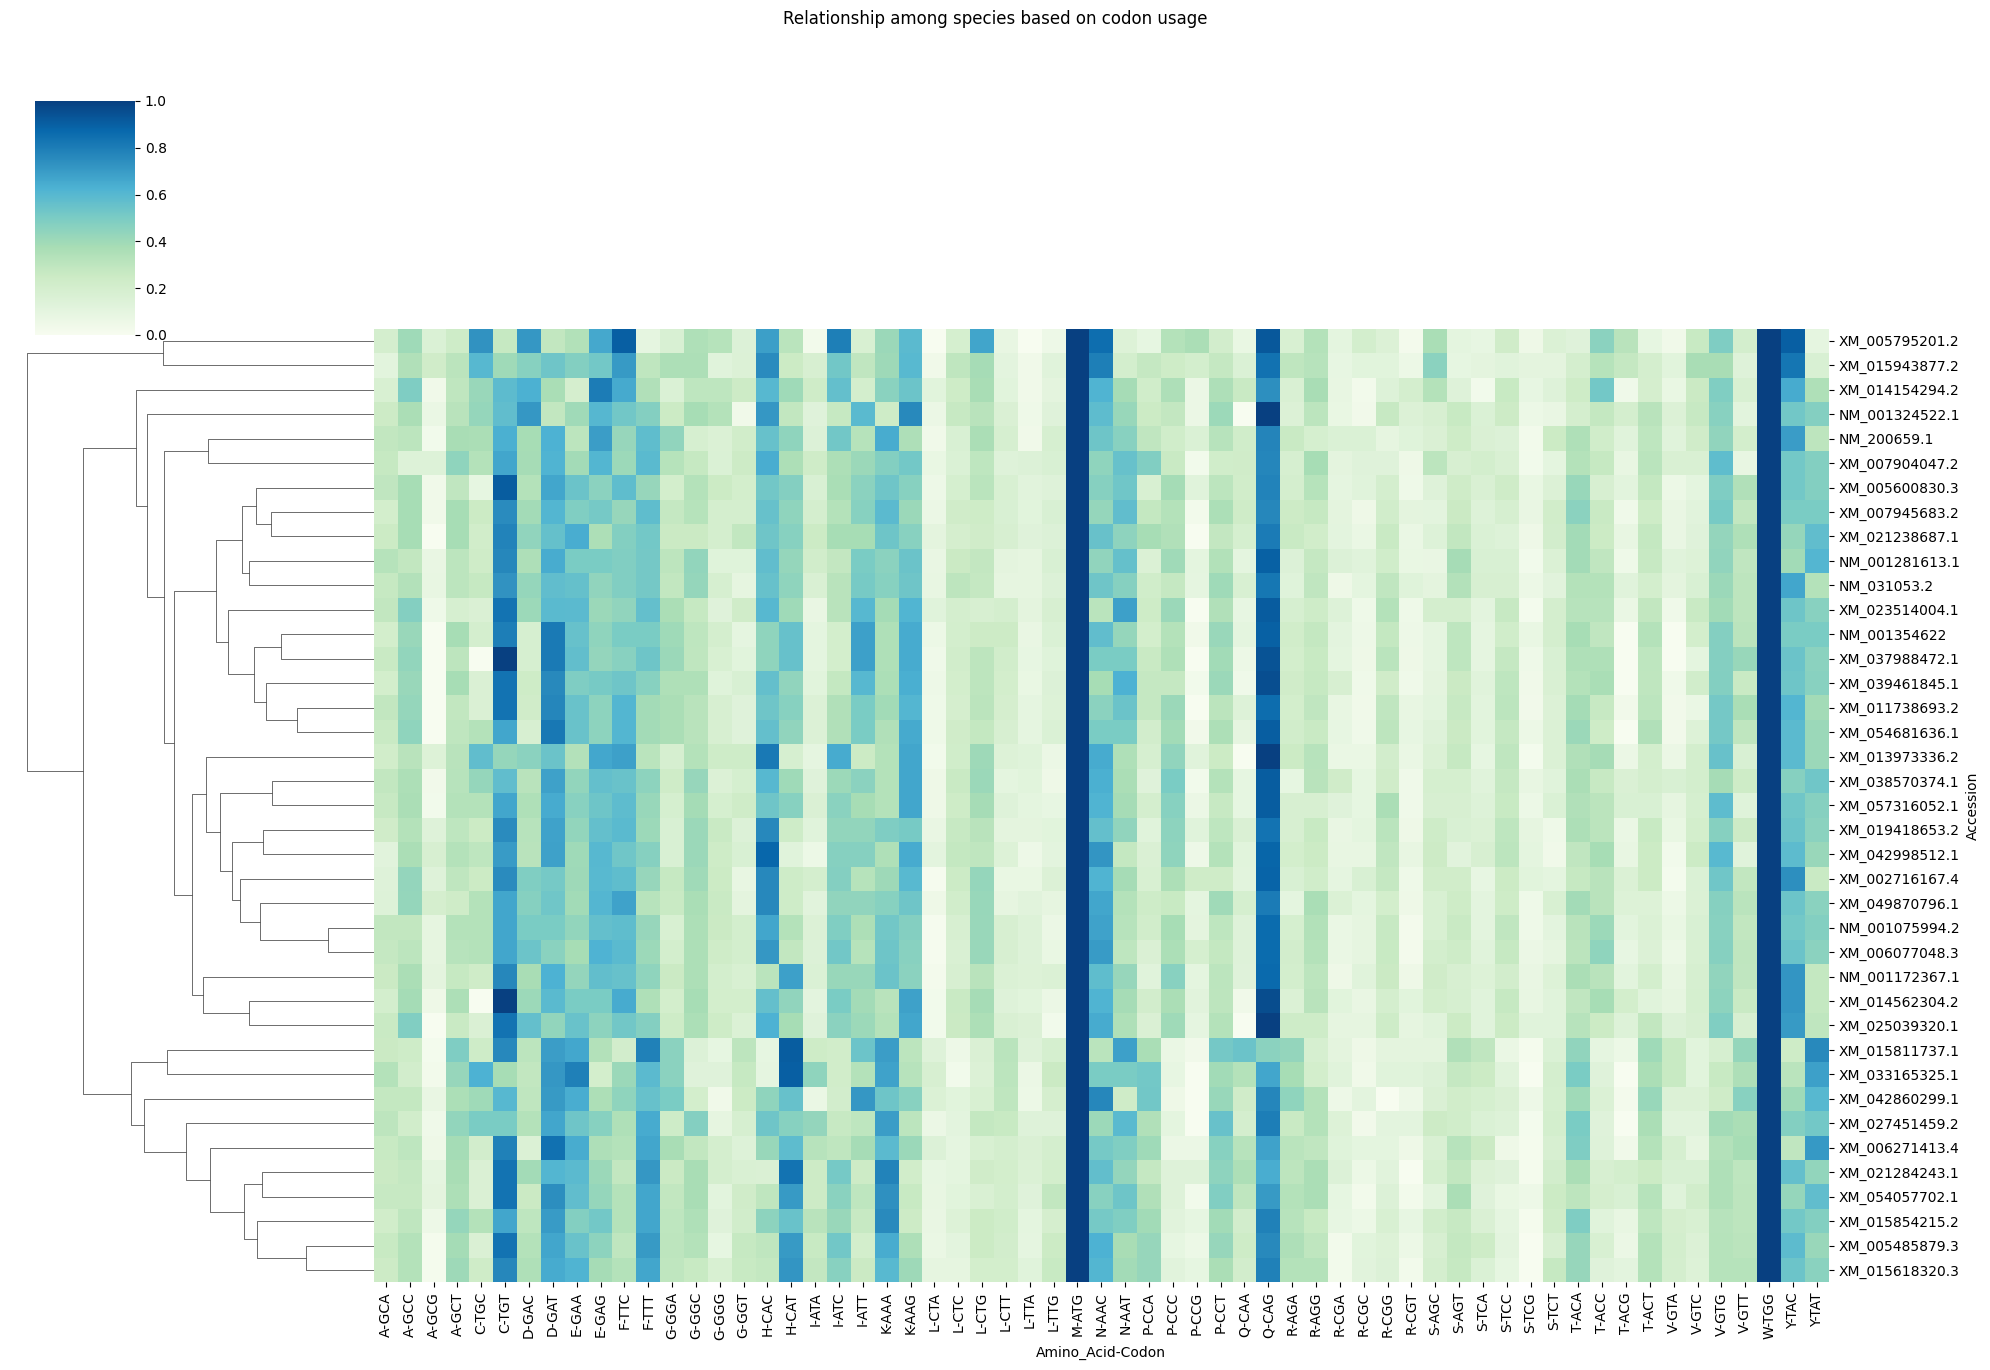

In [ ]:
def get_cod_freq(cds_features, genetic_code_table):

    """ Using cds features from NCBI Genbank sequences data and the
        genetic codon table as selected by the user, this function calcluates
        the codon frequency in the given sequences and creates a dataframe
        containing the codon, its corresponding amino acid and its observed
        frequency"""

    codon_count = dict()

    for codon in genetic_code_table.forward_table:
        codon_count[codon] = 0  # dictionary to accumulate codon count

    stop_codons = {'TGA', 'TAG', 'TAA'}

    for cds_feature in cds_features:
        cds_seq = str(cds_feature.extract(record.seq)).upper()
        codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3) if 'N' not in cds_seq[i:i+3] and len(cds_seq[i:i+3]) == 3 and cds_seq[i:i+3] not in stop_codons]

        for codon in codons:
            codon_count[codon] += 1

    df_codcount = pd.DataFrame(list(codon_count.items()))
    df_codcount.columns = ['Codon', 'Obs_Freq']
    df_codcount['Amino_Acid'] = [genetic_code_table.forward_table.get(codon, '') for codon in df_codcount['Codon'].values]

    return df_codcount

def compute_relative_freq(df_codcount):

    """ This function computes the relative frequency of each codon for each amino acid """

    df_codcount['Total_Freq'] = df_codcount.groupby('Amino_Acid')['Obs_Freq'].transform('sum')
    df_codcount['Relative_Freq'] = df_codcount['Obs_Freq'] / df_codcount['Total_Freq']

    return df_codcount

def get_optimal_codons(df_codcount):

    """ This function indicates the optimal codon for each amino acid"""

    aa = compute_relative_freq(df_codcount)['Amino_Acid'].unique()
    aa_groups = compute_relative_freq(df_codcount).groupby('Amino_Acid')
    df_list = []

    for a in aa:
        d = aa_groups.get_group(a).copy()  # Create a copy of the DataFrame
        d['optimal'] = False  # Initialize the 'optimal' column with False
        max_freq = d['Relative_Freq'].max()
        d.loc[d['Relative_Freq'] == max_freq, 'optimal'] = True
        df_list.append(d)

    return pd.concat(df_list)


def analyze_accession(accession, genetic_code_table):
    Entrez.email = 'emrunali@gmail.com'
    handle = Entrez.efetch(db='nucleotide', id=accession, rettype='gb', retmode='text')

    global record
    record = SeqIO.read(handle, "genbank")


    # Access CDS features
    cds_features = [feature for feature in record.features if feature.type == "CDS"]

    # Get codon frequencies
    df_codon_freq = get_cod_freq(cds_features, genetic_code_table)
    df_codon_freq = compute_relative_freq(df_codon_freq)
    df_codon_freq = get_optimal_codons(df_codon_freq)

    return df_codon_freq

def main(accession_list):

    # Allow the user to choose the genetic code table
    genetic_code_table_id = int(input("Enter the codon table ID (1-33): "))
    genetic_code_table = CodonTable.unambiguous_dna_by_id.get(genetic_code_table_id, CodonTable.unambiguous_dna_by_id[1])

    df_list = []

    for accession in accession_list:
        df_accession = analyze_accession(accession, genetic_code_table)
        df_list.append(df_accession)

    # Combine dataframes for each accession
    df_result = pd.concat(df_list, keys=accession_list, names=['Accession'])

    return df_result

accession_input = input("Enter comma-separated accession numbers: ")
accession_list = [acc.strip() for acc in accession_input.split(',')]
codon_usage_df = main(accession_list)

codon_usage_df.index = codon_usage_df.index.get_level_values('Accession')
codon_usage_df.reset_index()

codon_cluster= codon_usage_df.groupby(["Accession", "Codon", "Amino_Acid" ])["Relative_Freq"].first().unstack().unstack().dropna(axis=1, how='all')
plt.figure(figsize=(25,8))
sns.heatmap(codon_cluster, cmap="seismic")
plt.title("Comparison of codon usage");
plt.show()

g=sns.clustermap(
    codon_cluster,
    cmap="GnBu",
    col_cluster=False,
    figsize=(20,13),
)
g.fig.suptitle("Relationship among species based on codon usage", y=1.05);

XM_019418653.2, XM_042998512.1, XM_038570374.1, XM_057316052.1

XM_049870796.1, XM_007945683.2, XM_039461845.1, XM_037988472.1, XM_011738693.2, NM_001354622, XM_054681636.1

Animal Mlh1 sequences (39 sequences) - NM_001354622, NM_001324522.1, NM_031053.2, XM_038570374.1, NM_001075994.2, NM_001172367.1, XM_054681636.1, XM_054057702.1, XM_019418653.2, XM_006271413.4, NM_200659.1, XM_057316052.1,
 XM_037988472.1, XM_021284243.1, XM_002716167.4, XM_014154294.2, XM_027451459.2, XM_006077048.3, XM_042860299.1, XM_007904047.2, XM_015811737.1, XM_005485879.3, XM_025039320.1, XM_014562304.2, XM_015943877.2, XM_049870796.1, XM_021238687.1, XM_042998512.1, XM_007945683.2, NM_001281613.1, XM_039461845.1, XM_015618320.3, XM_015854215.2, XM_011738693.2, XM_005600830.3, XM_023514004.1, XM_005795201.2, XM_013973336.2, XM_033165325.1